In [1]:
import pandas as pd
import numpy as np
import yaml
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from catboost import CatBoostRegressor, Pool, EFeaturesSelectionAlgorithm
from collections import Counter
import optuna
import warnings
import pickle
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Функция для расчета WAPE (Weighted Absolute Percentage Error)
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [3]:
df = pd.read_csv('для модели v7.csv', parse_dates=['report_date'])

In [4]:
target_ = 'target_cost'

In [5]:
cat = df.copy()
cat.shape
# оставляем с непропущенными таргетом
cat=cat[cat[target_].notnull()]
cat.shape[0]

7087

In [6]:
def split_train_oot(data):
    # Находим самую позднюю дату в данных
    latest_date = data['report_date'].max()

    # Вычисляем дату, которая была три месяца назад от самой поздней даты
    three_months_ago = latest_date - pd.DateOffset(months=3)

    # Отбираем строки, где report_date попадает в последние три месяца
    data.loc[data['report_date'] >= three_months_ago, 'split_type'] = 'oot'

    # Теперь заполним NaN значения в столбце 'split_type' значением 'train'
    data.loc[data['split_type'].isna(), 'split_type'] = 'train'
    return data

In [7]:
# Функция для расчета всех метрик
def calculate_metrics(y_true, y_pred, dataset_name):
    return {
        'dataset': dataset_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'WAPE': wape(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'mean_target': y_true.mean(),
        'mean_pred': y_pred.mean(),
        'n_samples': len(y_true)
    }

In [8]:
def shap_gr(name_model, values):# Инициализация SHAP
    explainer = shap.TreeExplainer(name_model)
    shap_values = explainer.shap_values(values)

    # Создаем фигуру с регулируемым местом для шкалы
    plt.figure(figsize=(16, 8))

    ax1 = plt.axes([0.1, 0.1, 0.7, 0.8])  
    shap.summary_plot(shap_values, values,
                    max_display=20,
                    plot_type="dot",
                    color=plt.get_cmap("coolwarm"),
                    show=False,
                    plot_size=None)

    # Настройки графика
    ax1.set_title("Важность признаков по SHAP значениям", fontsize=14, pad=20)
    ax1.set_xlabel("Влияние на выход модели (SHAP value)", fontsize=12)
    ax1.set_ylabel("Признаки", fontsize=12)
    ax1.tick_params(labelsize=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    plt.show()

In [9]:
cat = split_train_oot(cat)

# Модель

# Тест 1

In [11]:
drop_cols = [
    'split_type', 
    'smt_building_addressid', 
    'sales__g_building__smt_projected_total_area__sum__1M', 
    'cost_net__g_building__sale_cost__sum__1M', 
    'report_date',
    'target_area', 
    target_
] 


In [12]:
# Разделяем данные
train_data = cat[cat['split_type'] == 'train']
test_data = cat[cat['split_type'] == 'oot']

# Подготовка признаков
X_train = train_data.drop(columns=drop_cols)
y_train = train_data[target_]

X_test = test_data.drop(columns=drop_cols)
y_test = test_data[target_]

# Инициализация и обучение модели
model = CatBoostRegressor(
    iterations=2000,
    depth=8,
    learning_rate=0.1,
    loss_function='MAE',
    l2_leaf_reg=3,
    random_strength=1,
    early_stopping_rounds=100,
    verbose=0
)
model.fit(X_train, y_train)

# Предсказания
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# Сохраняем результаты
metrics_df_base = metrics_df

In [13]:
metrics_df_base

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,1865.386966,3.186300e+07,5644.731817,0.010823,0.010046,0.987548,185685.752829,185366.093812,5958
1,test,19883.296825,8.057114e+08,28385.056469,0.098025,0.098353,0.770408,202162.258782,204964.810006,1129


# Отбор фич

In [14]:
cat = df.copy()
cat.shape
# оставляем с непропущенными таргетом
cat=cat[cat[target_].notnull()]
cat.shape[0]

7087

In [15]:
cat = split_train_oot(cat)

In [16]:
# Подготовка данных
cat['report_date'] = pd.to_datetime(cat['report_date'])
cat['year_month'] = cat['report_date'].dt.to_period('M').astype(str)

# Уникальные значения по времени в тренировочной выборке
train_df = cat[cat['split_type'] == 'train'].copy()

feature_columns = [col for col in cat.columns if col not in drop_cols]

# Список для сбора выбранных фич и метрик
features_across_splits = []
metrics_across_splits = []

# Инициализация TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Сортируем данные по дате для корректного разбиения
train_df = train_df.sort_values('report_date')

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_split = train_df.iloc[train_index]
    val_split = train_df.iloc[val_index]
    
    train_dates = train_split['report_date'].min(), train_split['report_date'].max()
    val_dates = val_split['report_date'].min(), val_split['report_date'].max()
    
    print(f"\n🔹 Сплит {fold}: train = {train_dates[0]} - {train_dates[1]}, val = {val_dates[0]} - {val_dates[1]}")
    
    # Создание Pool объектов
    train_pool = Pool(
        data=train_split[feature_columns],
        label=train_split[target_],
        cat_features=['year_month']
    )
    
    val_pool = Pool(
        data=val_split[feature_columns],
        label=val_split[target_],
        cat_features=['year_month']
    )

    # Инициализация модели
    model = CatBoostRegressor(
        iterations=1000,
        depth=6,
        learning_rate=0.05,
        loss_function='MAE',
        verbose=False,
        grow_policy='Lossguide'
    )
    # Обучение модели
    model.fit(train_pool, eval_set=val_pool)
    
    # Предсказания и метрики
    y_train_pred = model.predict(train_pool)
    y_val_pred = model.predict(val_pool)
    
    # Расчет метрик для train
    train_metrics = {
        'split': f'fold_{fold}_train',
        'start_date': train_dates[0],
        'end_date': train_dates[1],
        'n_samples': len(train_split),
        'mean_target': train_split[target_].mean(),
        'mean_pred': y_train_pred.mean(),
        'mae': mean_absolute_error(train_split[target_], y_train_pred),
        'rmse': np.sqrt(mean_squared_error(train_split[target_], y_train_pred)),
        'mape': mean_absolute_percentage_error(train_split[target_], y_train_pred),
        'wape': wape(train_split[target_], y_train_pred),
        'r2': r2_score(train_split[target_], y_train_pred)
    }
    
    # Расчет метрик для validation
    val_metrics = {
        'split': f'fold_{fold}_val',
        'start_date': val_dates[0],
        'end_date': val_dates[1],
        'n_samples': len(val_split),
        'mean_target': val_split[target_].mean(),
        'mean_pred': y_val_pred.mean(),
        'mae': mean_absolute_error(val_split[target_], y_val_pred),
        'rmse': np.sqrt(mean_squared_error(val_split[target_], y_val_pred)),
        'mape': mean_absolute_percentage_error(val_split[target_], y_val_pred),
        'wape': wape(val_split[target_], y_val_pred),
        'r2': r2_score(val_split[target_], y_val_pred)
    }
    
    metrics_across_splits.extend([train_metrics, val_metrics])
    
    # Отбор фичей
    selected_features = model.select_features(
        train_pool,
        eval_set=val_pool,
        features_for_select=feature_columns,
        num_features_to_select=100,
        steps=2,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        train_final_model=False,
        verbose=False
    )
    
    selected_features_names = [feature_columns[i] for i in selected_features['selected_features']]
    print(f" Отобрано фичей: {len(selected_features_names)}")
    features_across_splits.extend(selected_features_names)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame(metrics_across_splits)

# Форматируем даты 
metrics_df['start_date'] = metrics_df['start_date'].dt.strftime('%Y-%m-%d')
metrics_df['end_date'] = metrics_df['end_date'].dt.strftime('%Y-%m-%d')

# Переупорядочиваем столбцы
cols_order = ['split', 'start_date', 'end_date', 'n_samples', 'mean_target', 'mean_pred',
              'mae', 'rmse', 'mape', 'wape','r2']
metrics_df_select_features = metrics_df[cols_order]

# Анализ фичей
feature_counts = Counter(features_across_splits)
final_features = [f for f, count in feature_counts.items() if count >= 2]

print("\n Итоговые устойчивые фичи (встречались >= 2 раз):")
print("Количество:", len(final_features))



🔹 Сплит 1: train = 2022-03-01 00:00:00 - 2022-09-01 00:00:00, val = 2022-09-01 00:00:00 - 2023-03-01 00:00:00
Step #1 out of 2

bestTest = 18824.23614
bestIteration = 87

Shrink model to first 88 iterations.
Feature #585 eliminated
Feature #556 eliminated
Feature #571 eliminated
Feature #612 eliminated
Feature #528 eliminated
Feature #650 eliminated
Feature #760 eliminated
Feature #681 eliminated
Feature #626 eliminated
Feature #610 eliminated
Feature #535 eliminated
Feature #691 eliminated
Feature #598 eliminated
Feature #254 eliminated
Feature #550 eliminated
Feature #127 eliminated
Feature #290 eliminated
Feature #555 eliminated
Feature #858 eliminated
Feature #217 eliminated
Feature #831 eliminated
Feature #742 eliminated
Feature #564 eliminated
Feature #635 eliminated
Feature #629 eliminated
Feature #300 eliminated
Feature #833 eliminated
Feature #134 eliminated
Feature #845 eliminated
Feature #442 eliminated
Feature #638 eliminated
Feature #597 eliminated
Feature #439 eliminated

In [17]:
metrics_df_select_features

,split,start_date,end_date,n_samples,mean_target,mean_pred,mae,rmse,mape,wape,r2
0,fold_1_train,2022-03-01,2022-09-01,993,180561.158820,179618.570276,7127.649658,13640.834859,0.038774,0.039475,0.922103
1,fold_1_val,2022-09-01,2023-03-01,993,172763.010786,184587.418307,18668.817334,25220.828660,0.117008,0.108060,0.654353
2,fold_2_train,2022-03-01,2023-03-01,1986,176662.084803,176381.493583,5666.460275,12255.217873,0.033532,0.032075,0.929478
3,fold_2_val,2023-03-01,2023-08-01,993,176531.040187,171249.714494,14120.772765,20893.659348,0.077769,0.079990,0.756194
4,fold_3_train,2022-03-01,2023-08-01,2979,176618.403264,176511.665079,4986.092969,11316.799918,0.029779,0.028231,0.936494
5,fold_3_val,2023-08-01,2023-12-01,993,185026.132325,181051.342282,12274.705732,19705.638693,0.062626,0.066340,0.809913
6,fold_4_train,2022-03-01,2023-12-01,3972,178720.335529,178394.279862,5124.586511,11757.913757,0.029365,0.028674,0.932113
7,fold_4_val,2023-12-01,2024-03-01,993,197849.984250,190141.961919,14954.819809,28315.994751,0.067734,0.075587,0.752650
8,fold_5_train,2022-03-01,2024-03-01,4965,182546.265274,182009.802828,5862.081789,14218.232647,0.032144,0.032113,0.913460
9,fold_5_val,2024-03-01,2024-06-01,993,201383.190606,200403.884770,13019.503167,21464.280091,0.061527,0.064650,0.863600


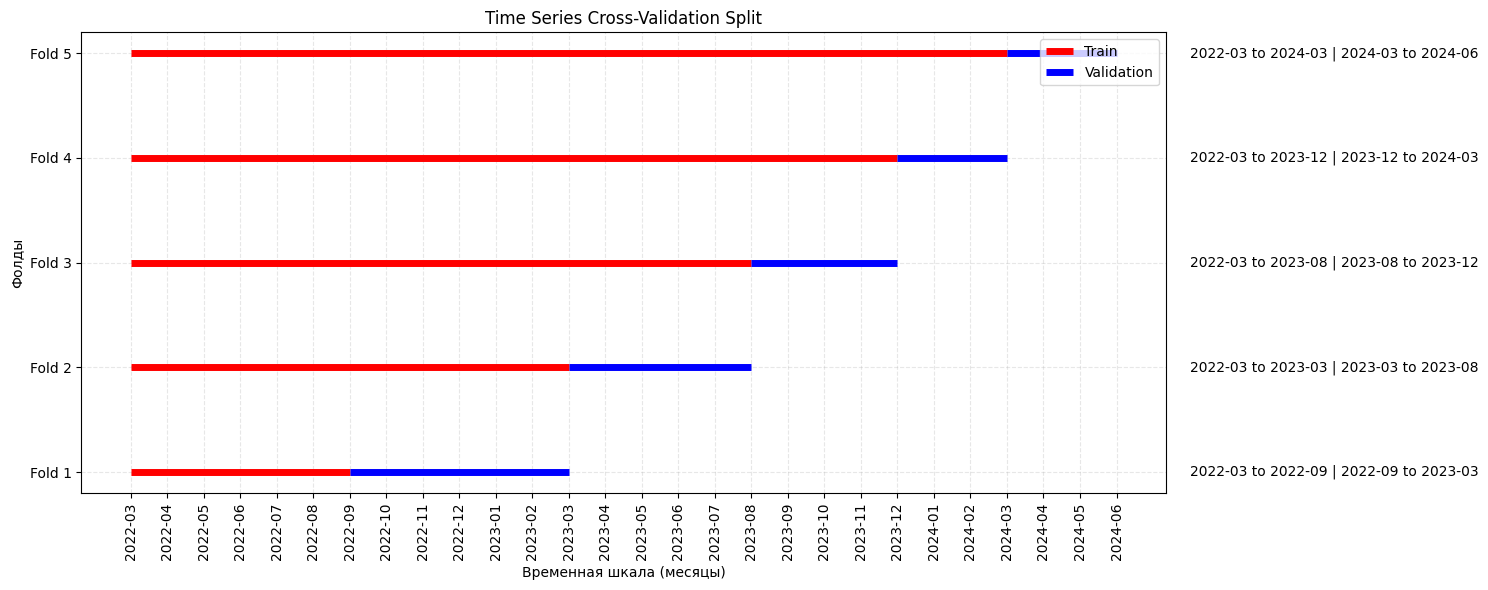

In [18]:
plt.figure(figsize=(15, 6))

# Получаем все уникальные даты
all_dates = np.sort(train_df['report_date'].unique())
date_labels = [str(date)[:7] for date in all_dates]  # Формат YYYY-MM

# Цвета для train/val
train_color = 'red'
val_color = 'blue'

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    # Находим индексы дат
    train_idx = [np.where(all_dates == d)[0][0] for d in train_dates]
    val_idx = [np.where(all_dates == d)[0][0] for d in val_dates]
    
    # Рисуем линии
    plt.hlines(y=fold, xmin=min(train_idx), xmax=max(train_idx), 
              color=train_color, linewidth=5, label='Train' if fold == 1 else "")
    plt.hlines(y=fold, xmin=min(val_idx), xmax=max(val_idx), 
              color=val_color, linewidth=5, label='Validation' if fold == 1 else "")

# Настройка графика
plt.yticks(range(1, tscv.n_splits+1), [f'Fold {i}' for i in range(1, tscv.n_splits+1)])
plt.xticks(range(len(all_dates)), date_labels, rotation=90)
plt.title('Time Series Cross-Validation Split')
plt.xlabel('Временная шкала (месяцы)')
plt.ylabel('Фолды')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper right')

# Добавим подписи дат для каждого фолда
for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    plt.text(x=len(all_dates)+1, y=fold, 
             s=f"{train_dates[0].strftime('%Y-%m')} to {train_dates[-1].strftime('%Y-%m')} | {val_dates[0].strftime('%Y-%m')} to {val_dates[-1].strftime('%Y-%m')}",
             ha='left', va='center')

plt.tight_layout()
plt.show()

In [19]:
filtered_df = cat[list(set(cat.columns) & set(final_features))]
filtered_df.head(3)

,rosstat_q__g_rd__num_mortgage_loans_resident__avg__1_4Q,area__g_building__smt_projected_total_area__rooms_3plus_free__count,expon_cost__g_building__pc_cost_diff__rooms_0__min__1M,expon_cost__g_building__pc_cost_diff__avg__1_4M,expon_cost__g_building__pc_cost_diff__rooms_2__max__12M,floor__g_building__smt_floor__rooms_2__avg,sales__g_building__sale_price__rooms_0__sum__1_600M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__max__12M,expon_cost__g_building__pc_cost_diff__rooms_0__avg__1M,mortgages__g_building__smt_loan_period__avg__1_600M,...,area__g_building__smt_projected_total_area__str_r__sum,expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__min__3M,expon_cost__g_building__pc_cost_diff__min__3M,expon_cost__g_building__pc_cost__rooms_1__max__1M,expon_cost__g_building__pc_cost_diff_rel__rooms_2__max__3M,sales__g_building__sale_cost__rooms_0__min__1_600M,rosstat_m__g_rd__overdue_debt_loans_resident__last2avg__1_12M,sales__g_building__sale_cost__rooms_3plus__min__1_600M,expon_cost_change__g_building__pc_cost_rooms_3plus_avg__curdiffirst2first__3M,sales__g_building__sale_price__sum__6M
11,110572.164,NaN,NaN,1370.0,NaN,9.197803,NaN,NaN,NaN,NaN,...,0.0,NaN,1370.0,0.0,NaN,NaN,1.060260,NaN,NaN,NaN
12,110572.164,86.0,5265.0,1370.0,NaN,9.197803,NaN,NaN,5265.000,360.40000,...,25124.1,NaN,5265.0,176755.0,NaN,NaN,1.045962,NaN,0.0,147893940.0
13,110572.164,87.0,-10390.0,5265.0,-7652.0,9.197803,13523355.0,-0.049997,-10015.655,341.82144,...,21433.5,-0.050003,-10390.0,176755.0,-0.049997,178095.02,1.052437,158426.9,0.0,724442100.0


In [20]:
# Разделение столбцов
numeric_cols =filtered_df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = filtered_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Числовые столбцы:", numeric_cols)
print("Категориальные столбцы:", categorical_cols)

Числовые столбцы: ['rosstat_q__g_rd__num_mortgage_loans_resident__avg__1_4Q', 'area__g_building__smt_projected_total_area__rooms_3plus_free__count', 'expon_cost__g_building__pc_cost_diff__rooms_0__min__1M', 'expon_cost__g_building__pc_cost_diff__avg__1_4M', 'expon_cost__g_building__pc_cost_diff__rooms_2__max__12M', 'floor__g_building__smt_floor__rooms_2__avg', 'sales__g_building__sale_price__rooms_0__sum__1_600M', 'expon_cost__g_building__pc_cost_diff_rel__rooms_1__max__12M', 'expon_cost__g_building__pc_cost_diff__rooms_0__avg__1M', 'mortgages__g_building__smt_loan_period__avg__1_600M', 'mortgages__g_building__required_amount__min__1M', 'expon_cost__g_building__pc_cost_diff__min__12M', 'reservations__g_building__min_reservation_date__max', 'mortgages__g_building__loan_amount__max__6M', 'floor__g_building__smt_floor__rooms_1__avg', 'mortgages__g_building__initial_fee__avg__3M', 'area__g_building__smt_projected_total_area__avg', 'expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__max

In [21]:
# Создаем словарь для YAML
data = {
    'numeric_columns': numeric_cols,
    'categorical_columns': categorical_cols,
    'id': ['smt_building_addressid'],
    'date' : ['report_date'],
    'target' : [target_]
}

# Записываем в YAML-файл
with open('features_model_cost.yml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

In [22]:
# загрузим фичи
with open('features_model_cost.yml', 'r') as file:
    config = yaml.safe_load(file)

# 2. Извлечение списков столбцов
numeric_cols = config.get('numeric_columns', [])
target_cols = config.get('target', [])
id_col = config.get('id', [])
date_col = config.get('date', [])
all_config_columns = numeric_cols + categorical_cols+id_col+date_col+target_cols

In [23]:
filtered_df = cat[list(set(cat.columns) & set(all_config_columns))].reset_index(drop=True)
filtered_df.head(5)

,rosstat_q__g_rd__num_mortgage_loans_resident__avg__1_4Q,area__g_building__smt_projected_total_area__rooms_3plus_free__count,expon_cost__g_building__pc_cost_diff__rooms_0__min__1M,expon_cost__g_building__pc_cost_diff__avg__1_4M,expon_cost__g_building__pc_cost_diff__rooms_2__max__12M,floor__g_building__smt_floor__rooms_2__avg,sales__g_building__sale_price__rooms_0__sum__1_600M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__max__12M,expon_cost__g_building__pc_cost_diff__rooms_0__avg__1M,mortgages__g_building__smt_loan_period__avg__1_600M,...,area__g_building__smt_projected_total_area__str_r__sum,expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__min__3M,expon_cost__g_building__pc_cost_diff__min__3M,expon_cost__g_building__pc_cost__rooms_1__max__1M,expon_cost__g_building__pc_cost_diff_rel__rooms_2__max__3M,sales__g_building__sale_cost__rooms_0__min__1_600M,rosstat_m__g_rd__overdue_debt_loans_resident__last2avg__1_12M,sales__g_building__sale_cost__rooms_3plus__min__1_600M,expon_cost_change__g_building__pc_cost_rooms_3plus_avg__curdiffirst2first__3M,sales__g_building__sale_price__sum__6M
0,110572.164,NaN,NaN,1370.0000,NaN,9.197803,NaN,NaN,NaN,NaN,...,0.0,NaN,1370.0,0.0,NaN,NaN,1.060260,NaN,NaN,NaN
1,110572.164,86.0,5265.00,1370.0000,NaN,9.197803,NaN,NaN,5265.0000,360.40000,...,25124.1,NaN,5265.0,176755.0,NaN,NaN,1.045962,NaN,0.0,1.478939e+08
2,110572.164,87.0,-10390.00,5265.0000,-7652.00,9.197803,13523355.0,-0.049997,-10015.6550,341.82144,...,21433.5,-0.050003,-10390.0,176755.0,-0.049997,178095.02,1.052437,158426.90,0.0,7.244421e+08
3,106712.800,86.0,0.01,-8682.2950,5131.99,9.197803,57686668.0,0.030000,943.5466,337.24518,...,18036.5,-0.050003,-10390.0,180425.0,0.030006,170004.70,1.052546,140383.11,0.0,1.311990e+09
4,106712.800,87.0,5654.00,-1678.4677,5301.00,9.197803,117890730.0,0.030005,5750.4443,337.57996,...,16517.1,-0.050003,-10390.0,180425.0,0.030006,170004.70,1.045713,138496.06,0.0,1.543108e+09


In [24]:
filtered_df = split_train_oot(filtered_df)

# Модель 2 на выбранных фичах

In [25]:
# Разделим данные на тренировочные и тестовые
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

# Выберите признаки (features) и целевую переменную (target)
# Допустим, у вас есть столбец 'target', который нужно предсказать
X_train = train_data.drop(columns=['split_type','smt_building_addressid', 'report_date',
                     target_])  
y_train = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date',
                         target_])  
y_test = test_data[target_]

# Инициализируем модель 
model = CatBoostRegressor(
                    iterations=2000,  
                    depth=8,         
                    learning_rate=0.1,  # Уменьшаем learning rate
                    loss_function='MAE',  
                    l2_leaf_reg=3,   
                    random_strength=1,
                    early_stopping_rounds=100,  # Ранняя остановка
                    verbose=200,
                    grow_policy='Lossguide'  # Альтернативная стратегия роста
                )
# Обучаем модель на тренировочных данных
model.fit(X_train, y_train)

# Делаем предсказания 
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Предсказания
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# Сохраняем результаты
metrics_df_with_select_features = metrics_df

0:	learn: 34172.3577870	total: 6.74ms	remaining: 13.5s
200:	learn: 7581.1995457	total: 1.59s	remaining: 14.3s
400:	learn: 6292.3129976	total: 3.31s	remaining: 13.2s
600:	learn: 5624.8534767	total: 4.95s	remaining: 11.5s
800:	learn: 5225.4362348	total: 6.59s	remaining: 9.86s
1000:	learn: 4929.2483897	total: 8.22s	remaining: 8.21s
1200:	learn: 4690.8169001	total: 9.82s	remaining: 6.54s
1400:	learn: 4512.6249595	total: 11.4s	remaining: 4.89s
1600:	learn: 4361.2242671	total: 13s	remaining: 3.25s
1800:	learn: 4225.0329559	total: 14.7s	remaining: 1.62s
1999:	learn: 4108.4492912	total: 16.3s	remaining: 0us


In [26]:
metrics_df_with_select_features

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,4108.449239,1.171805e+08,10824.993241,0.023166,0.022126,0.954207,185685.752829,185473.345168,5958
1,test,19813.401604,7.365610e+08,27139.657440,0.102124,0.098007,0.790112,202162.258782,211229.126685,1129


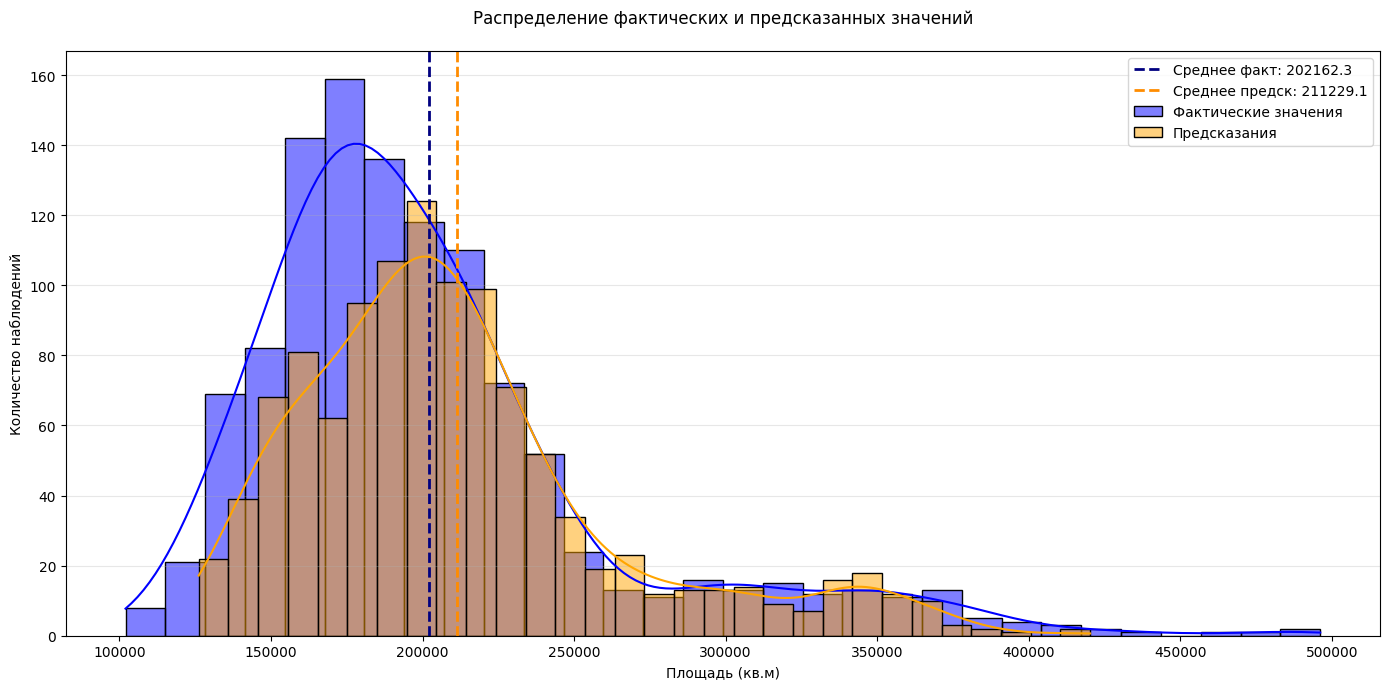

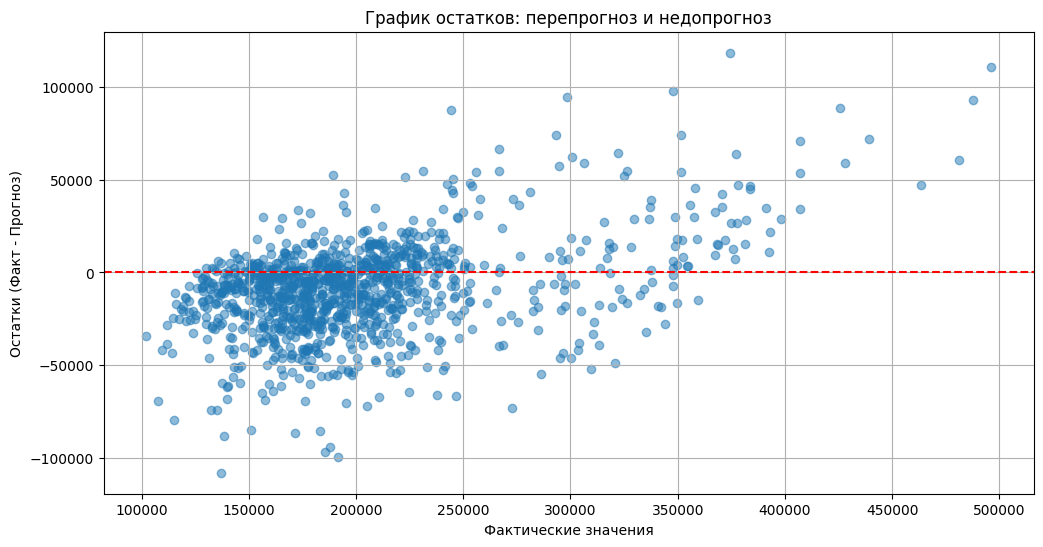

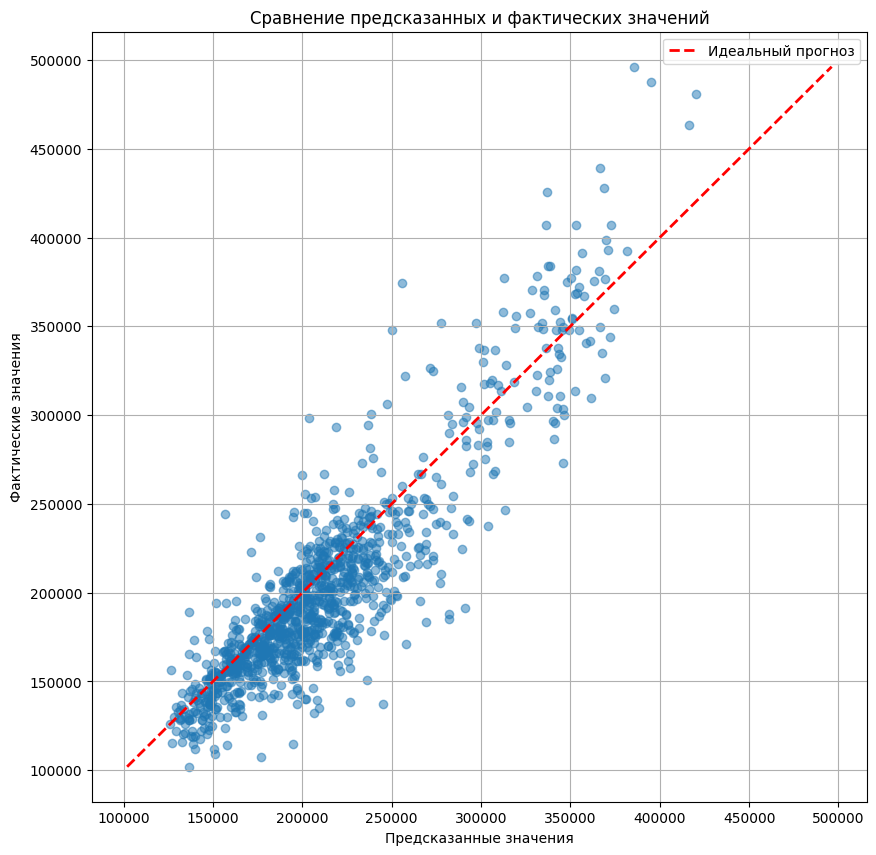

In [27]:
# 1. Анализ распределения таргета и предиктов
plt.figure(figsize=(14, 7))

# Гистограмма с наложением KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='Фактические значения', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='Предсказания', kde=True, ax=ax)

# Добавляем линии средних
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'Среднее факт: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Среднее предск: {test_pred.mean():.1f}')

plt.title('Распределение фактических и предсказанных значений', pad=20)
plt.xlabel('Площадь (кв.м)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. График перепрогноза/недопрогноза
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков: перепрогноз и недопрогноз')
plt.xlabel('Фактические значения')
plt.ylabel('Остатки (Факт - Прогноз)')
plt.grid()
plt.show()

# 3. Скэттерплот с диагональной линией
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='Идеальный прогноз')
plt.title('Сравнение предсказанных и фактических значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.legend()
plt.grid()
plt.show()

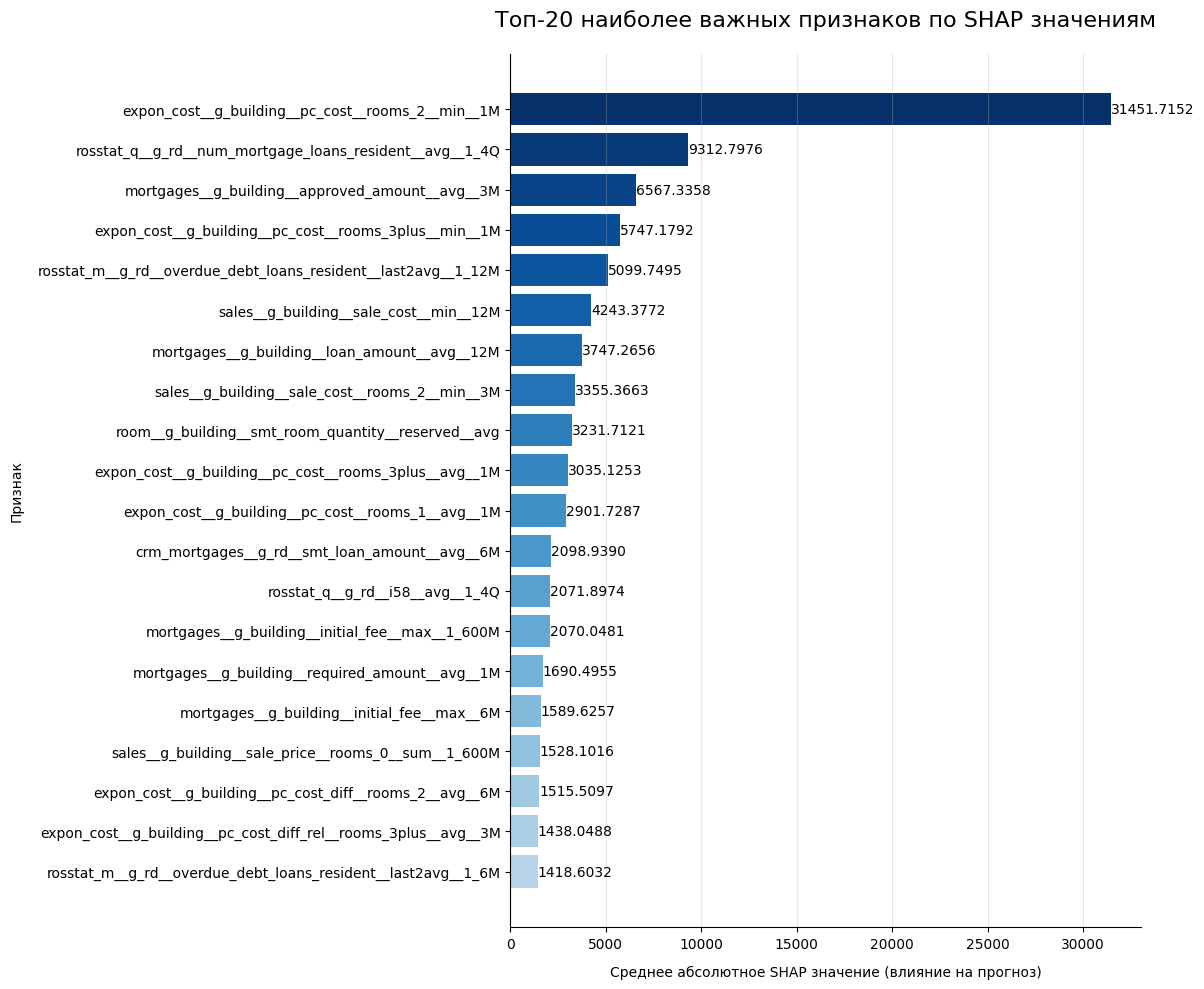

In [28]:
# Инициализация и расчет SHAP значений
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Создаем DataFrame с важностью фич
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False).head(20)

# Стилизация графика
plt.figure(figsize=(12, 10))

# Горизонтальный bar plot с цветовой градацией
colors = plt.cm.Blues(np.linspace(0.3, 1, len(shap_importance)))
bars = plt.barh(shap_importance['feature'][::-1], 
                shap_importance['importance'][::-1],
                color=colors)

# Добавляем значения на график
for bar in bars:
    width = bar.get_width()
    plt.text(width, 
             bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', 
             ha='left', 
             va='center')

# Настройки внешнего вида
plt.title('Топ-20 наиболее важных признаков по SHAP значениям', pad=20, fontsize=16)
plt.xlabel('Среднее абсолютное SHAP значение (влияние на прогноз)', labelpad=10)
plt.ylabel('Признак', labelpad=10)
plt.grid(axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


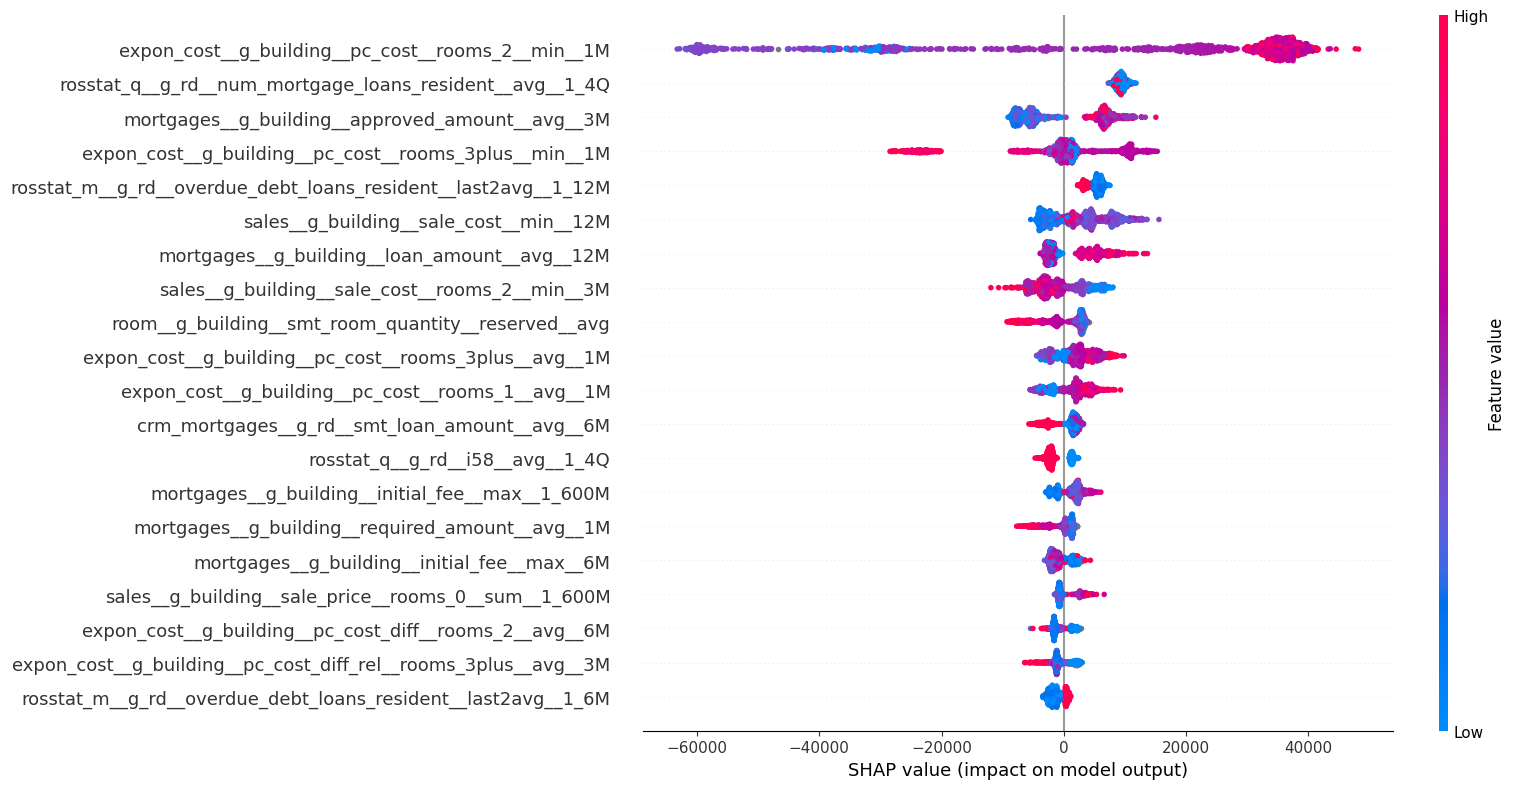

In [29]:
shap_gr(model, X_test)

# OPTUNA

In [30]:
# Разделяем данные
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

X_train_full = train_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date',target_])
y_train_full = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date', target_])
y_test = test_data[target_]

# Делим часть train на train/valid для Optuna
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                    test_size=0.2, random_state=42)

# Для CatBoost нужно указывать cat_features
cat_features = ['year_month'] if 'year_month' in X_train.columns else []

# Улучшенная оптимизация через Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 3.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "loss_function": "MAE",
        "early_stopping_rounds": 100,
        "verbose": False,
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Lossguide", "Depthwise"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    # Добавляем параметры в зависимости от типа бутстрапа
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), 
             cat_features=cat_features, early_stopping_rounds=100, verbose=0)
    
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# Улучшенный запуск Optuna
study = optuna.create_study(direction="minimize",
                          sampler=optuna.samplers.TPESampler(seed=42),
                          pruner=optuna.pruners.HyperbandPruner())

study.optimize(objective, n_trials=30)  

print("Лучшие параметры:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

# Обучаем финальную модель с лучшими параметрами
best_params = study.best_params.copy()
best_params.update({
    "loss_function": "MAE",
    "early_stopping_rounds": 100,
    "verbose": 100,
    "task_type": "CPU",  
})

# Удаляем параметры, которые не нужны в финальной модели
for param in ['iterations', 'early_stopping_rounds']:
    if param in best_params:
        del best_params[param]

final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train_full, y_train_full,
               cat_features=cat_features,
               early_stopping_rounds=100,
               verbose=100)

# Делаем предсказания 
train_pred = final_model.predict(X_train_full)
test_pred = final_model.predict(X_test)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train_full, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# Сохраняем результаты
metrics_df_optuna = metrics_df

[I 2025-05-19 23:24:16,688] A new study created in memory with name: no-name-e178df48-dc63-427e-a5d8-74098a402b15
[I 2025-05-19 23:24:21,272] Trial 0 finished with value: 11079.694221679378 and parameters: {'iterations': 1749, 'depth': 8, 'learning_rate': 0.029106359131330698, 'l2_leaf_reg': 0.24810409748678114, 'random_strength': 0.5524540572830658, 'border_count': 66, 'min_data_in_leaf': 6, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6061695553391381}. Best is trial 0 with value: 11079.694221679378.
[I 2025-05-19 23:24:23,312] Trial 1 finished with value: 12812.850706228233 and parameters: {'iterations': 1363, 'depth': 4, 'learning_rate': 0.004059611610484304, 'l2_leaf_reg': 0.12561043700013563, 'random_strength': 1.3526405540621358, 'border_count': 97, 'min_data_in_leaf': 62, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7571172192068059}. Best is trial 0 with value: 11079.694221679378.
[I 2025-05-19 23:24:26,181] Trial 2

Лучшие параметры:
iterations: 2005
depth: 8
learning_rate: 0.020469317534302804
l2_leaf_reg: 0.1486391322130916
random_strength: 0.3862697980288674
border_count: 102
min_data_in_leaf: 72
grow_policy: Depthwise
bootstrap_type: MVS
0:	learn: 35863.4002838	total: 6.1ms	remaining: 6.1s
100:	learn: 12891.0375233	total: 623ms	remaining: 5.54s
200:	learn: 9653.5974749	total: 1.17s	remaining: 4.63s
300:	learn: 8728.4106005	total: 1.65s	remaining: 3.83s
400:	learn: 8167.5900821	total: 2.1s	remaining: 3.14s
500:	learn: 7704.3953907	total: 2.56s	remaining: 2.55s
600:	learn: 7365.9129392	total: 3.01s	remaining: 2s
700:	learn: 7061.0749460	total: 3.49s	remaining: 1.49s
800:	learn: 6817.6199127	total: 3.97s	remaining: 988ms
900:	learn: 6631.8423854	total: 4.43s	remaining: 487ms
999:	learn: 6473.0974995	total: 4.88s	remaining: 0us


In [31]:
metrics_df_optuna

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,6473.097464,2.012761e+08,14187.181868,0.034705,0.034860,0.921343,185685.752829,185218.710787,5958
1,test,19550.730316,7.453694e+08,27301.453482,0.099563,0.096708,0.787602,202162.258782,210184.100767,1129


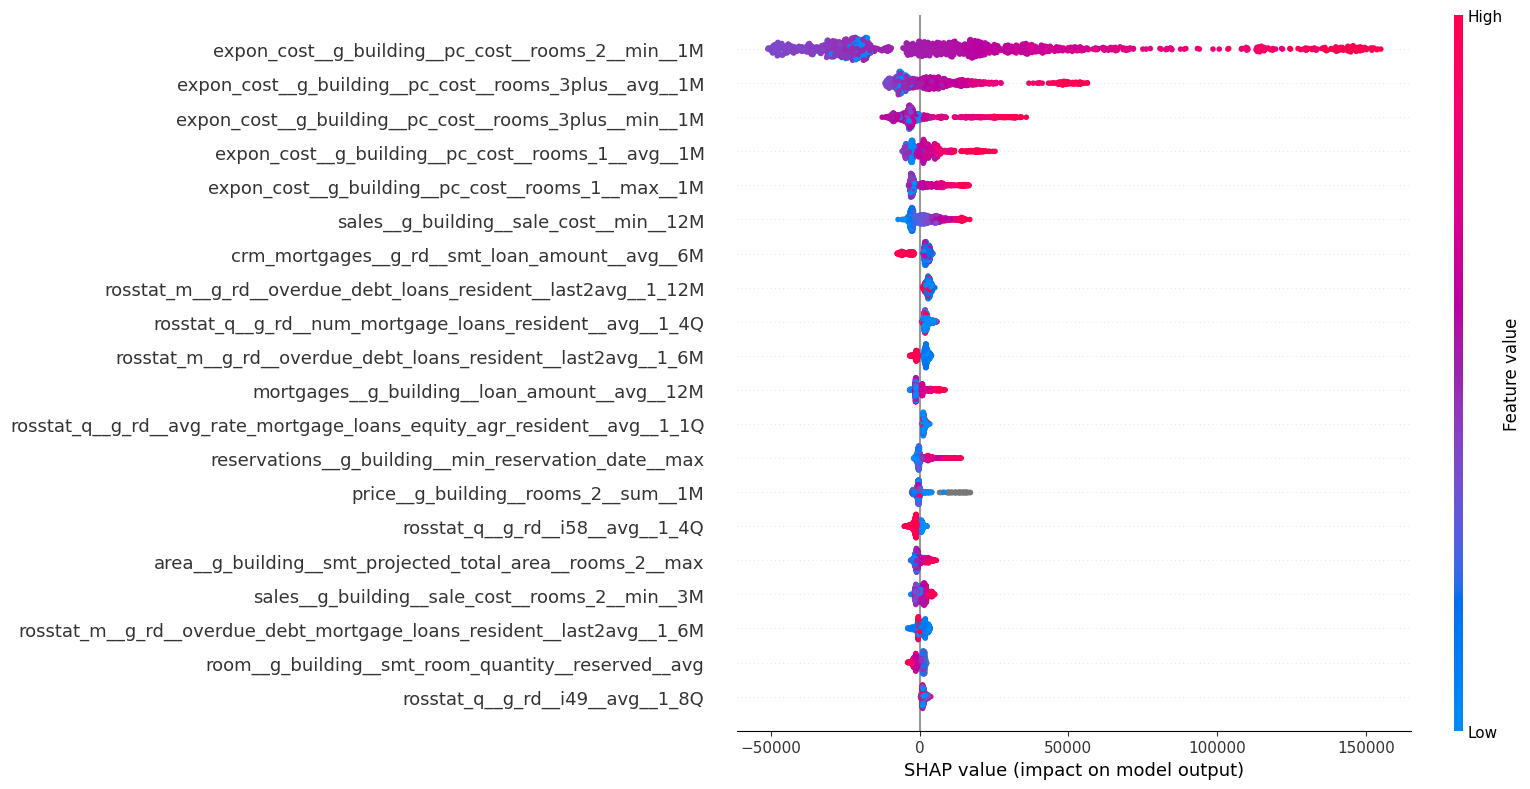

In [32]:
shap_gr(final_model, X_test)

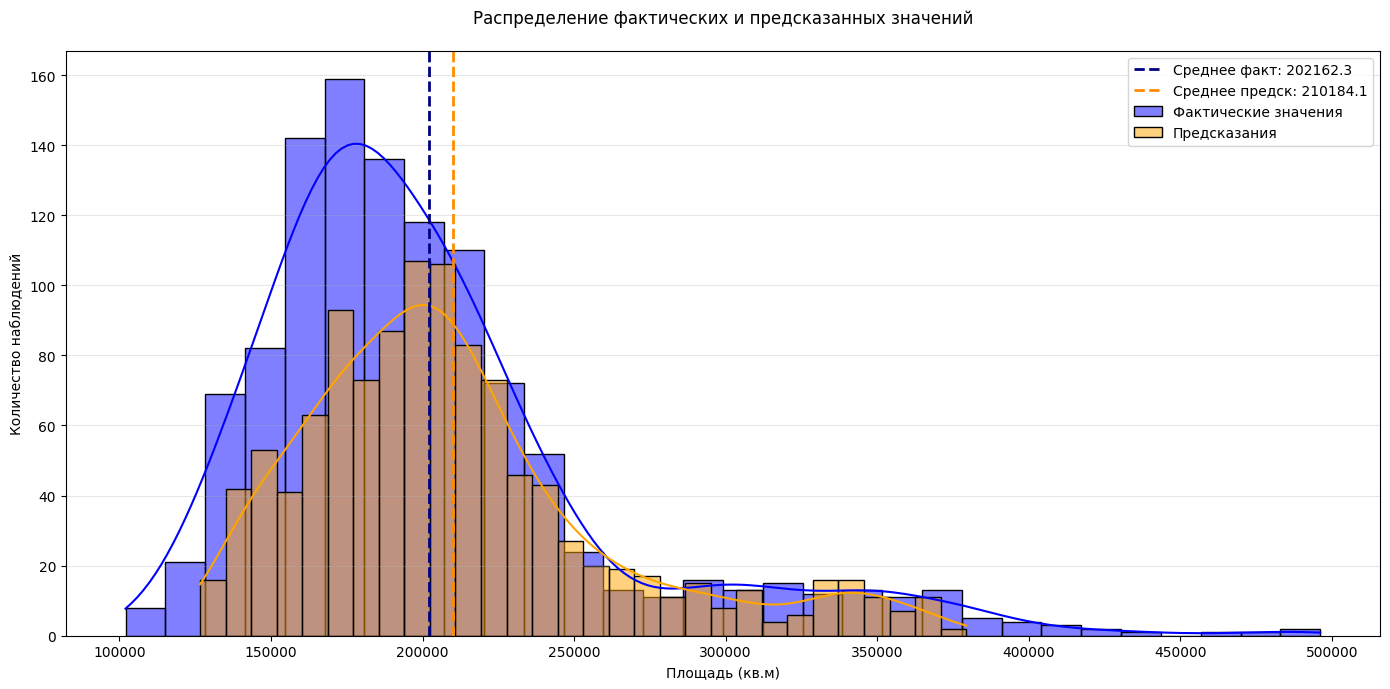

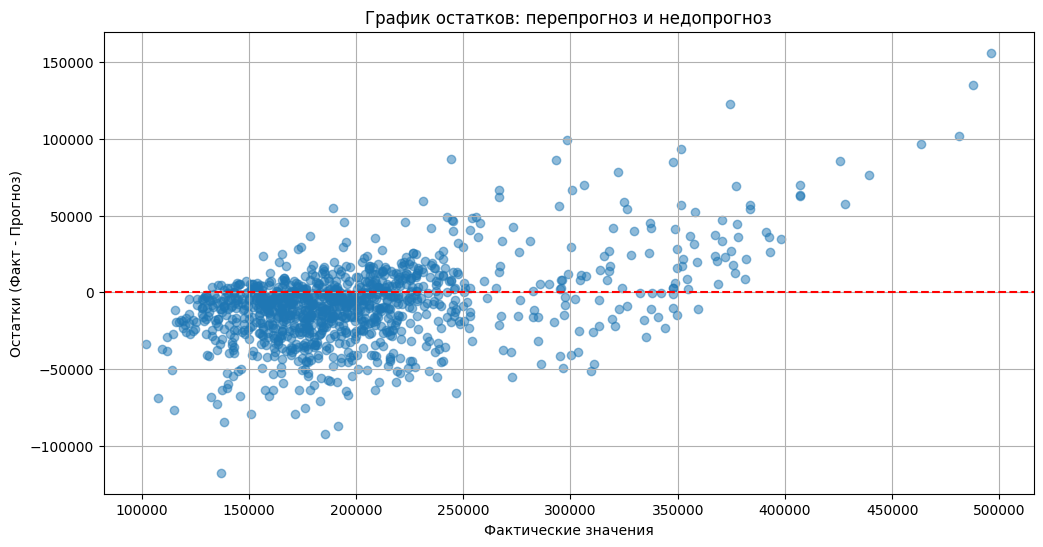

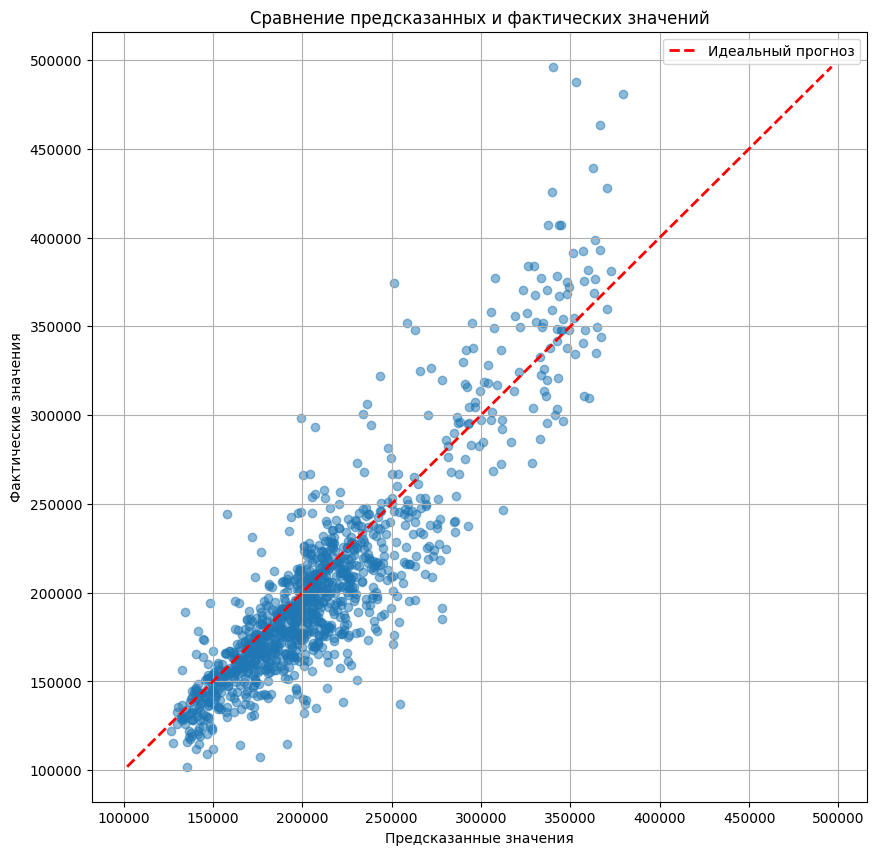

In [33]:
# 1. Анализ распределения таргета и предиктов
plt.figure(figsize=(14, 7))

# Гистограмма с наложением KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='Фактические значения', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='Предсказания', kde=True, ax=ax)

# Добавляем линии средних
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'Среднее факт: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Среднее предск: {test_pred.mean():.1f}')

plt.title('Распределение фактических и предсказанных значений', pad=20)
plt.xlabel('Площадь (кв.м)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. График перепрогноза/недопрогноза
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков: перепрогноз и недопрогноз')
plt.xlabel('Фактические значения')
plt.ylabel('Остатки (Факт - Прогноз)')
plt.grid()
plt.show()

# 3. Скэттерплот с диагональной линией
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='Идеальный прогноз')
plt.title('Сравнение предсказанных и фактических значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.legend()
plt.grid()
plt.show()


In [34]:
metrics_df_base.insert(0, 'stage', 'Базовая модель')
metrics_df_with_select_features.insert(0, 'stage', 'Модель с отбором признаков')
metrics_df_optuna.insert(0, 'stage', 'Оптимизированная модель (Optuna)')

In [35]:
result = pd.concat([metrics_df_base,metrics_df_with_select_features,metrics_df_optuna], ignore_index=True)
result

,stage,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,Базовая модель,train,1865.386966,3.186300e+07,5644.731817,0.010823,0.010046,0.987548,185685.752829,185366.093812,5958
1,Базовая модель,test,19883.296825,8.057114e+08,28385.056469,0.098025,0.098353,0.770408,202162.258782,204964.810006,1129
2,Модель с отбором признаков,train,4108.449239,1.171805e+08,10824.993241,0.023166,0.022126,0.954207,185685.752829,185473.345168,5958
3,Модель с отбором признаков,test,19813.401604,7.365610e+08,27139.657440,0.102124,0.098007,0.790112,202162.258782,211229.126685,1129
4,Оптимизированная модель (Optuna),train,6473.097464,2.012761e+08,14187.181868,0.034705,0.034860,0.921343,185685.752829,185218.710787,5958
5,Оптимизированная модель (Optuna),test,19550.730316,7.453694e+08,27301.453482,0.099563,0.096708,0.787602,202162.258782,210184.100767,1129


In [36]:
# Сохраняем модель
with open('model_cost.pkl', 'wb') as f:
    pickle.dump(final_model, f)